In [1]:
!pip install yfinance

In [2]:
import yfinance as yf #making connection with the Yahoo finance
import pandas as pd #importing basic python library
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

Identify all tickers of the companies

In [3]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TCS', 'INFY']

In [4]:
data_list = []

In [5]:
for ticker in tickers:
    data = yf.download(ticker, start='2020-01-01', end='2023-01-01')
    data['Ticker'] = ticker  # Add the Ticker column
    data_list.append(data)  # Append the DataFrame to the list

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
stock_data = pd.concat(data_list)   #prepare a dataset
stock_data.reset_index(inplace=True)

In [7]:
stock_data.head() #showing all the sdata columns of the dataset

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,72.876122,135480400,AAPL
1,2020-01-03,74.287498,75.144997,74.125000,74.357498,72.167618,146322800,AAPL
2,2020-01-06,73.447502,74.989998,73.187500,74.949997,72.742653,118387200,AAPL
3,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.400543,108872000,AAPL
4,2020-01-08,74.290001,76.110001,74.290001,75.797501,73.565208,132079200,AAPL


In [8]:
stock_data.to_csv('stock_data.csv', index=False) #save the dataset

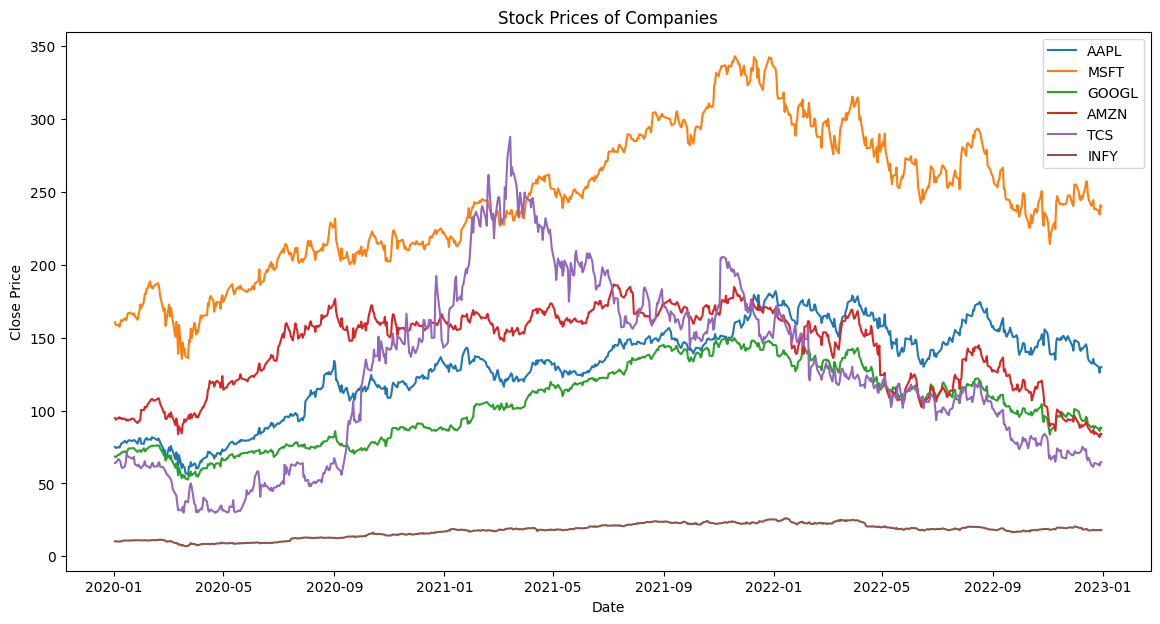

In [9]:
#comparision of different companies data based on close price
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(stock_data[stock_data['Ticker'] == ticker]['Date'],
             stock_data[stock_data['Ticker'] == ticker]['Close'],
             label=ticker)
plt.title('Stock Prices of Companies')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [10]:
for ticker in tickers:
    stock_data['Pct_Change'] = stock_data['Close'].pct_change()

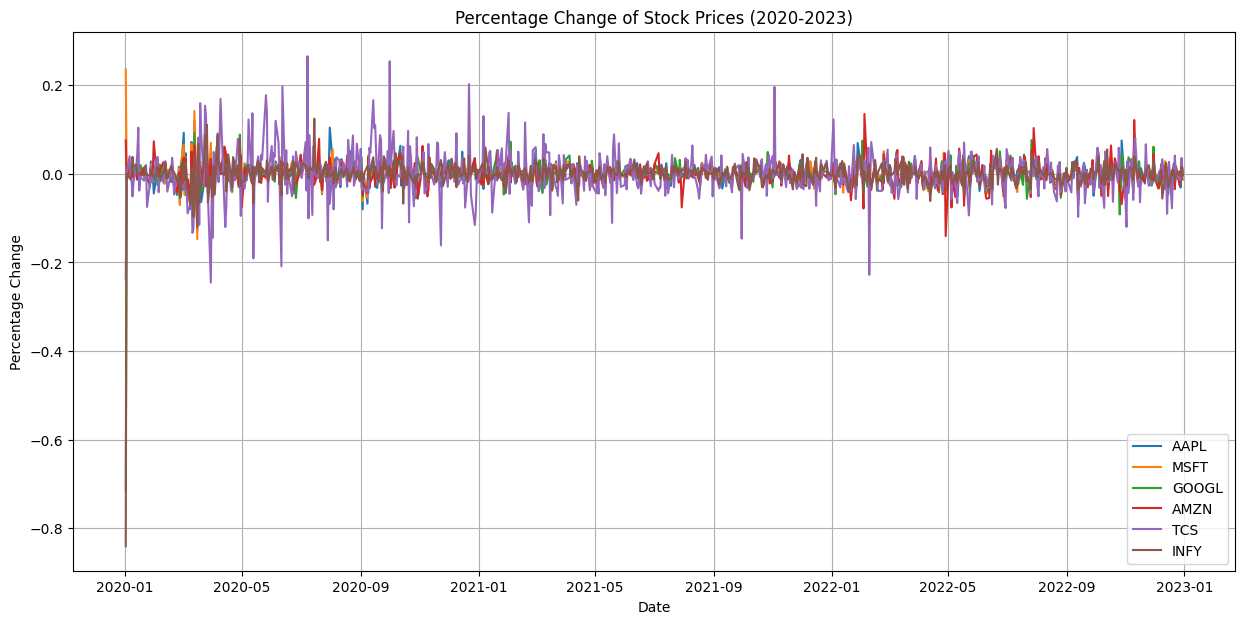

In [11]:
#percentage change in closing prices
plt.figure(figsize=(15, 7))
for ticker in tickers:
    subset = stock_data[stock_data['Ticker'] == ticker]
    plt.plot(subset['Date'], subset['Pct_Change'], label=ticker)
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.title('Percentage Change of Stock Prices (2020-2023)')
plt.legend()
plt.grid(True)
plt.show()


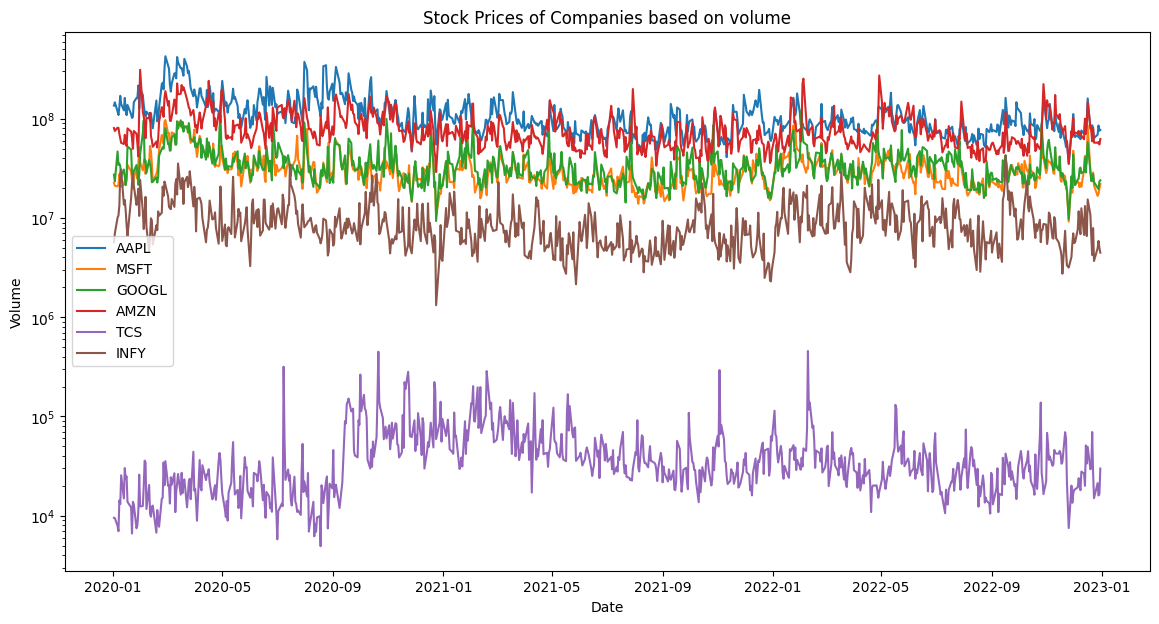

In [12]:
#Stock Prices of Companies based on volume
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(stock_data[stock_data['Ticker'] == ticker]['Date'],
             stock_data[stock_data['Ticker'] == ticker]['Volume'],
             label=ticker)
plt.title('Stock Prices of Companies based on volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.yscale("log")
plt.legend()
plt.show()

In [13]:
for ticker in tickers:
    stock_data['MarktCap'] = stock_data['Open'] * stock_data['Volume']

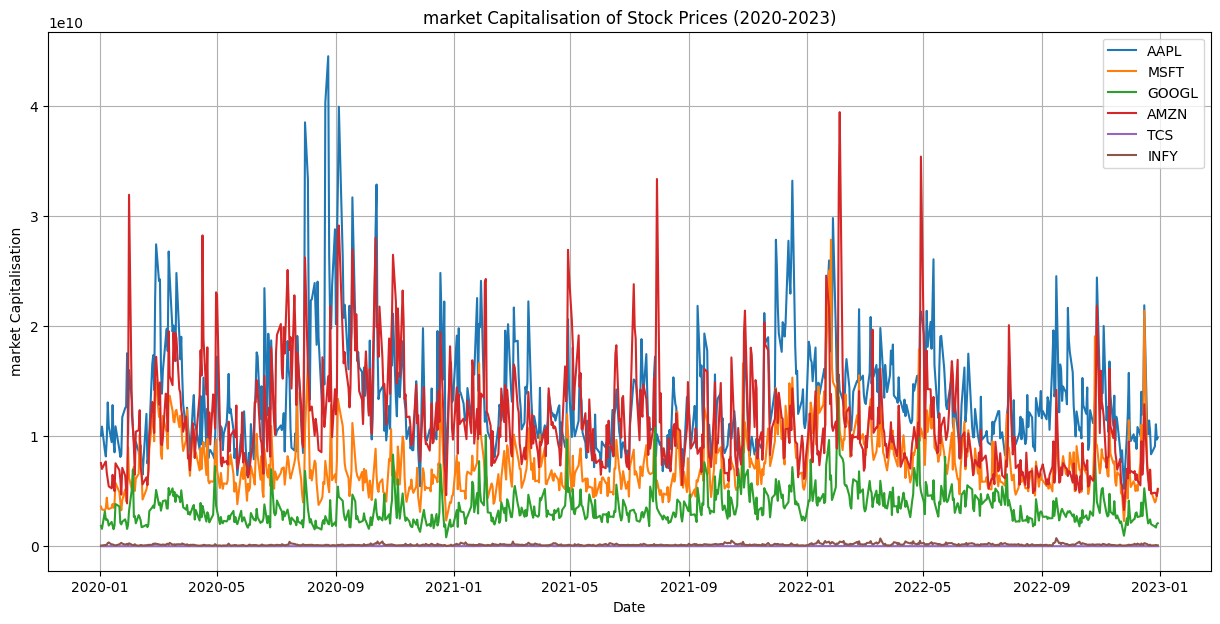

In [14]:
#analysing market Capitalisation
plt.figure(figsize=(15, 7))
for ticker in tickers:
    subset = stock_data[stock_data['Ticker'] == ticker]
    plt.plot(subset['Date'], subset['MarktCap'], label=ticker)
plt.xlabel('Date')
plt.ylabel('market Capitalisation')
plt.title('market Capitalisation of Stock Prices (2020-2023)')
plt.legend()
plt.grid(True)
plt.show()

K-means algorithm

In [15]:
from sklearn.cluster import KMeans

In [16]:
scaler = MinMaxScaler()
stock_data[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(stock_data[['Open', 'High', 'Low', 'Close', 'Volume']])


In [17]:
features = ['Open', 'High', 'Low', 'Close', 'Volume'] #determining the features of the dataset
X = stock_data[features].values

In [18]:
#kmeans algorithm
kmeans = KMeans(n_clusters=6, random_state=42)
stock_data['Cluster'] = kmeans.fit_predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


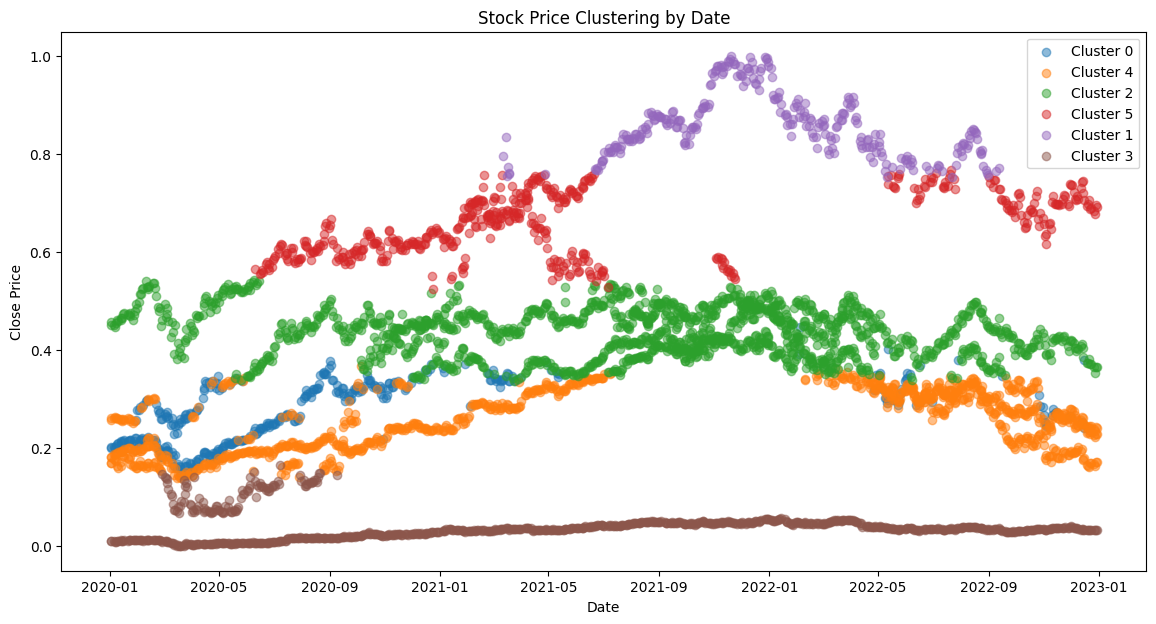

In [19]:
#scatter plot for Kmeans
plt.figure(figsize=(14, 7))
for cluster in stock_data['Cluster'].unique():
    cluster_data = stock_data[stock_data['Cluster'] == cluster]
    plt.scatter(cluster_data['Date'], cluster_data['Close'], label=f'Cluster {cluster}', alpha=0.5)
plt.title('Stock Price Clustering by Date')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [20]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [21]:
def process_data(ticker_data, time_step=60): #prepare a dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(ticker_data[['Close']])

    X, y = create_dataset(scaled_data, time_step)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    return X, y, scaler

In [22]:
def train_lstm(X_train, y_train): #train LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)
    return model


In [23]:
def forecast(ticker_data, model, scaler, time_step=60):   #Making a function for forecasting analysis
    scaled_data = scaler.transform(ticker_data[['Close']])
    X, _ = create_dataset(scaled_data, time_step)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    predictions = model.predict(X)
    predictions = scaler.inverse_transform(predictions)

    plt.figure(figsize=(14, 7))
    plt.plot(ticker_data.index[time_step+1:], ticker_data['Close'][time_step+1:], label='Actual Prices')
    plt.plot(ticker_data.index[time_step+1:], predictions, label='Predicted Prices')
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - loss: 0.1754
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0122
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0034
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0026
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 0.0021
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - loss: 0.0021
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0019
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0021
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0021
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0021
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


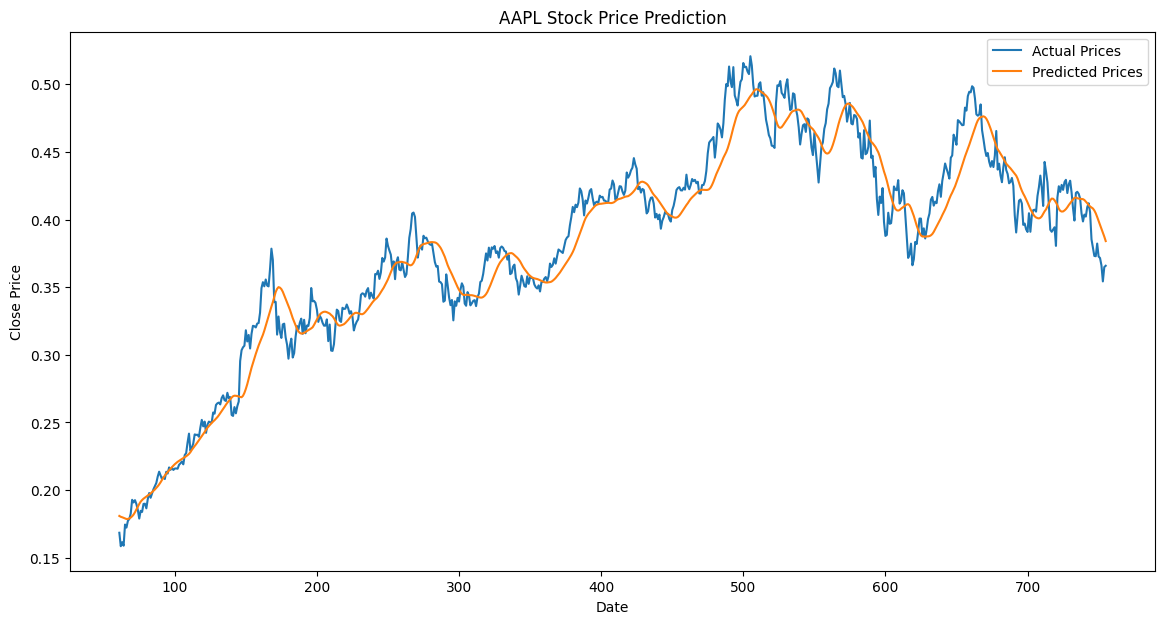

In [24]:
ticker = 'AAPL'
ticker_data = stock_data[stock_data['Ticker'] == ticker].copy()
X, y, scaler = process_data(ticker_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = train_lstm(X_train, y_train)
forecast(ticker_data, model, scaler)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.1381
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0087
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0031
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0021
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0018
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0018
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0017
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0017
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0019
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0018
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


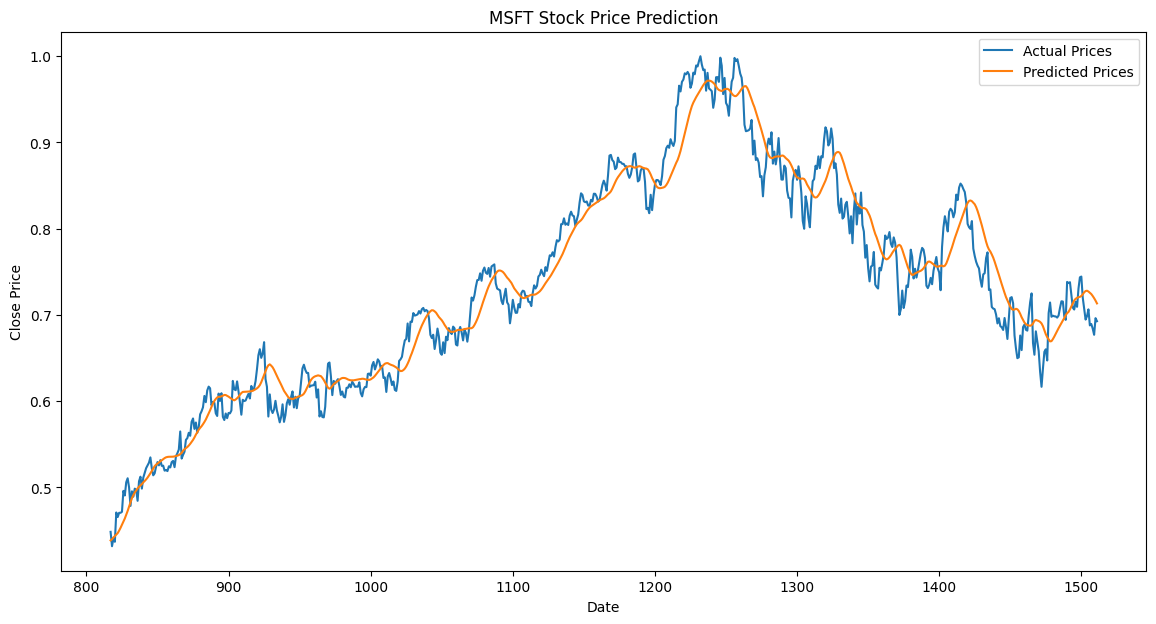

In [25]:
ticker = 'MSFT'
ticker_data = stock_data[stock_data['Ticker'] == ticker].copy()
X, y, scaler = process_data(ticker_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = train_lstm(X_train, y_train)
forecast(ticker_data, model, scaler)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.2993
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0095
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0055
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0027
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0018
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0018
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0018
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0018
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0018
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0018
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


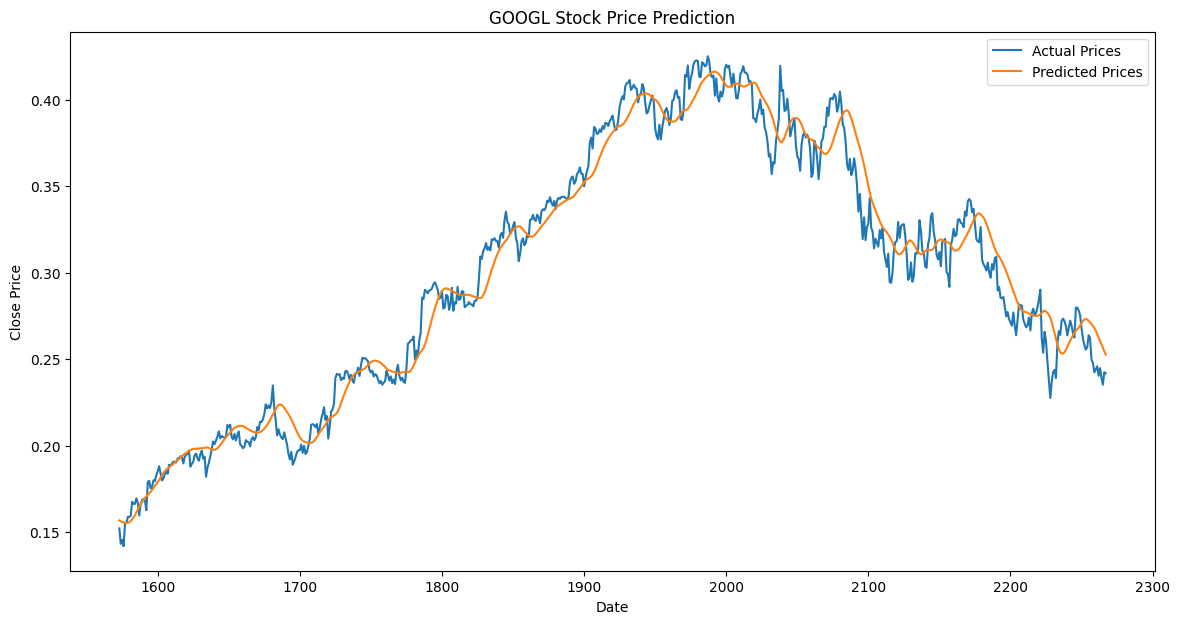

In [26]:
ticker = 'GOOGL'
ticker_data = stock_data[stock_data['Ticker'] == ticker].copy()
X, y, scaler = process_data(ticker_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = train_lstm(X_train, y_train)
forecast(ticker_data, model, scaler)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0999
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0082
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0066
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0056
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0050
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0046
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0048
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0053
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0045
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0033
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


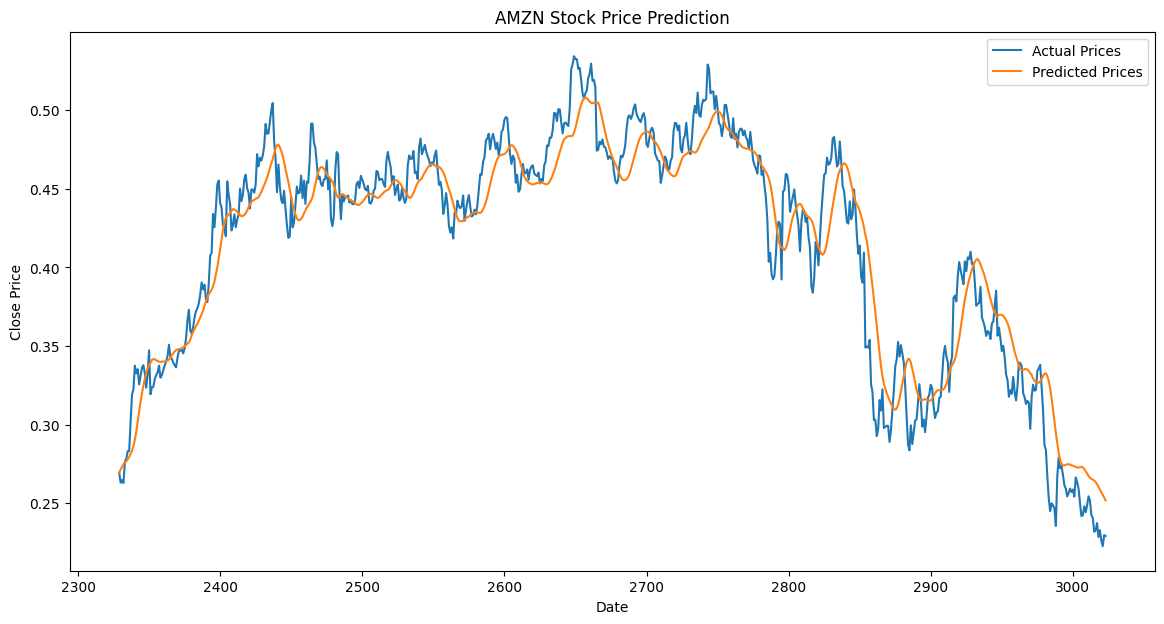

In [27]:
ticker = 'AMZN'
ticker_data = stock_data[stock_data['Ticker'] == ticker].copy()
X, y, scaler = process_data(ticker_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = train_lstm(X_train, y_train)
forecast(ticker_data, model, scaler)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0978
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0089
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0044
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0033
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0027
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0025
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0025
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0023
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0023
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0020
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


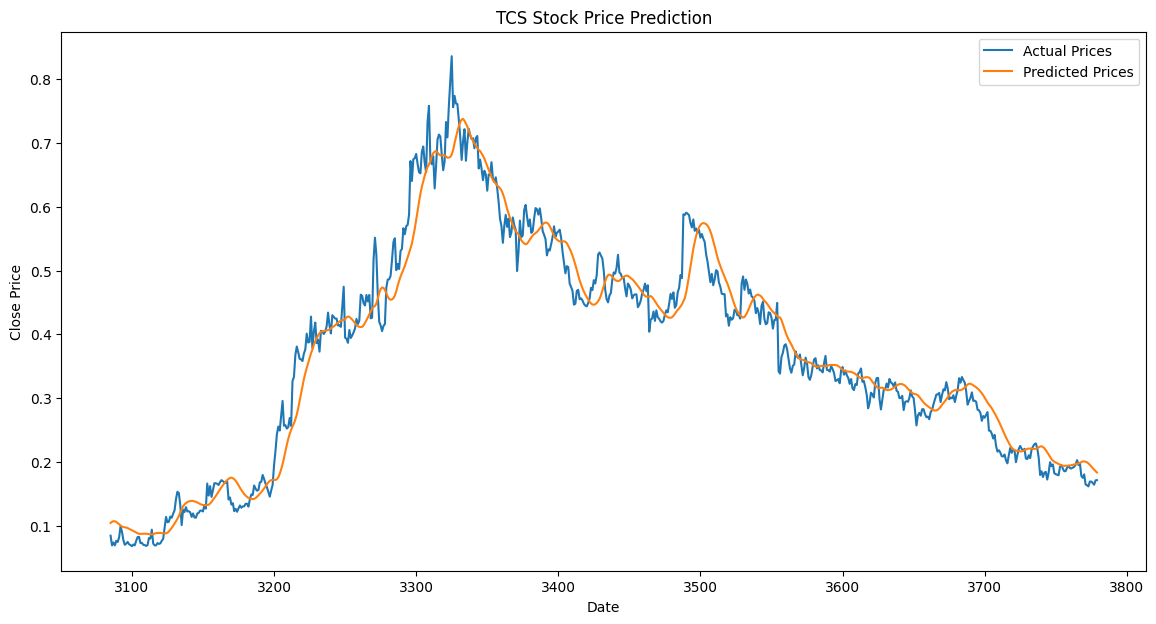

In [28]:
ticker = 'TCS'
ticker_data = stock_data[stock_data['Ticker'] == ticker].copy()
X, y, scaler = process_data(ticker_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = train_lstm(X_train, y_train)
forecast(ticker_data, model, scaler)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.1669
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0145
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0040
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0023
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0015
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0018
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0015
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0016
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0015
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0014
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


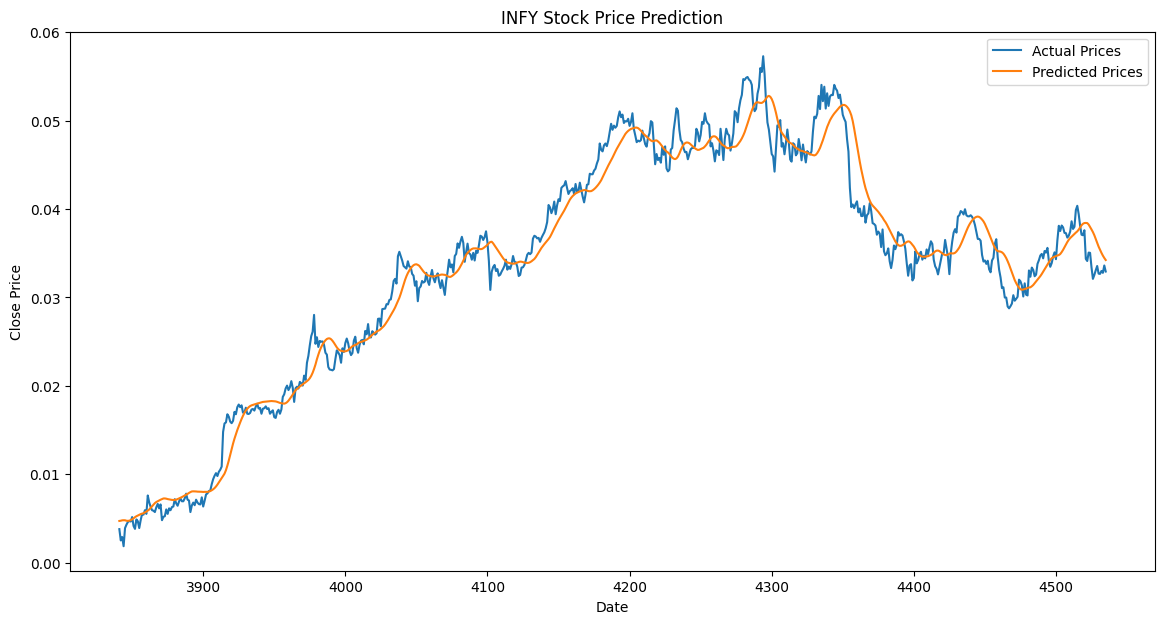

In [29]:
ticker = 'INFY'
ticker_data = stock_data[stock_data['Ticker'] == ticker].copy()
X, y, scaler = process_data(ticker_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = train_lstm(X_train, y_train)
forecast(ticker_data, model, scaler)